In [21]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Concatenate, Dense, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
from scipy.stats import norm
import tensorflow_probability

In [22]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

rng = np.random.RandomState(120)  # For reproducibility of results

# ============================
# Specifying Hyper-parameters:
# ============================

num_epochs = 8000  # Setting the number of training epochs
batch_size = 32 # Setting the size of training batches
num_select = 100  # Amount of data points available

sigma_x1 = 0.01  # Tune how far from original data points is sampled (x1 dimension)
sigma_x2 = 0.001  # Tune how far from original data points is sampled (x2 dimension)
sigma_x3 = 0.01 
sigma_x4 = 0.02
sigma_x5 = 0.03
sigma_x6 = 0.01 
sigma_x7 = 0.5 
sigma_x8 = 0.2 
sigma_x9=0.05

mean_prior_weight = 0.01
noise_prior_weight = 20
nll_weight=2
nll_weight2=3
nll_weight3=5
nll_weight4=3

p_error=0.2


initial_lr = 0.001  # Setting the learning rate for the optimizer
decay_rate = 0.5  # Decay of the learning rate scheduler


# In[88]:


plasma0=pd.read_csv('../data/europed_predictions_more_input.csv')
def myscaler(data):
    std=data.std()
    mean=data.mean()
    return (data-mean)/std,mean,std
plasma0=plasma0[(plasma0['Ip[MA]']!=0)&(plasma0['Te_ped_exp']!=0)&(plasma0['beta_n_exp']!=0)]
plasma0['epsilon']=plasma0['rminor[m]']/plasma0['Rmag[M]']
mu0=4*np.pi*10**(-7)
plasma0['mu'] = (mu0 /(2*np.pi)) * 1e6 * plasma0['Ip[MA]'] / (plasma0['Bt[T]'] * plasma0['rminor[m]'])

plasma0['Delta_SC']=plasma0.Delta_EPED*np.sqrt(plasma0.Te_ped_SC/plasma0.Te_ped_EPED)
plasma=myscaler(plasma0)[0]

sigmay2=(plasma0.Delta_exp*0.1).abs()/myscaler(plasma0.Delta_exp)[2]
sigmay2[sigmay2==0]=0.00001
plasma['Sigma_Te_ped_exp']=(0.05*plasma0.Te_ped_exp).abs()/myscaler(plasma0.Te_ped_exp)[2]#5%

plasma['Sigma_Delta_exp']=sigmay2
plasma['Sigma_beta']= (0.1*plasma0.beta_n_exp).abs()/myscaler(plasma0.beta_n_exp)[2]#10%
plasma['Sigma_neped']= (0.1*plasma0.ne_ped_exp).abs()/myscaler(plasma0.ne_ped_exp)[2]#10%

selected_dataset=plasma0.loc[:,['mu', 'Bt[T]', 'epsilon', 'kappa', 'Triang.',
     'P_tot[MW]',  'Gas[1e22/s]', 'Zeff_h','Delta_exp',  'Te_ped_exp', 'ne_ped_exp','beta_n_exp']]






train,test=train_test_split(plasma.loc[:,['mu', 'Bt[T]', 'epsilon', 'kappa', 'Triang.',
     'P_tot[MW]',  'Gas[1e22/s]', 'Zeff_h','Delta_exp',  'Te_ped_exp', 'ne_ped_exp','beta_n_exp','Sigma_Te_ped_exp','Sigma_Delta_exp','Sigma_neped','Sigma_beta']],test_size=0.098,shuffle=True,random_state=2)
sigma_x1 = 0.02/myscaler(selected_dataset)[2][0]#mu
sigma_x2 = 0.001/myscaler(selected_dataset)[2][1]#Bt
sigma_x3 = 0.01/myscaler(selected_dataset)[2][2] #eps
sigma_x4 = 0.01/myscaler(selected_dataset)[2][3]#kap
sigma_x5 = 0.01/myscaler(selected_dataset)[2][4]#trian
sigma_x6 = 0.5/myscaler(selected_dataset)[2][5]#ptot
sigma_x7 = 0.2/myscaler(selected_dataset)[2][6]#gas
sigma_x8 = 0.05/myscaler(selected_dataset)[2][7]#zeff



x1_train=tf.constant(train.loc[:,'mu'].values, dtype=tf.float32)
x2_train=tf.constant(train.loc[:,'Bt[T]'].values, dtype=tf.float32)
x3_train=tf.constant(train.loc[:,'epsilon'].values, dtype=tf.float32)
x4_train=tf.constant(train.loc[:,'kappa'].values, dtype=tf.float32)
x5_train=tf.constant(train.loc[:,'Triang.'].values, dtype=tf.float32)
x6_train=tf.constant(train.loc[:,'P_tot[MW]'].values, dtype=tf.float32)
x7_train=tf.constant(train.loc[:,'Gas[1e22/s]'].values, dtype=tf.float32)
x8_train=tf.constant(train.loc[:,'Zeff_h'].values, dtype=tf.float32)
y_train=tf.constant(train.loc[:,'Delta_exp'].values, dtype=tf.float32)
y2_train=tf.constant(train.loc[:,'Te_ped_exp'].values, dtype=tf.float32)
y3_train=tf.constant(train.loc[:,'ne_ped_exp'].values, dtype=tf.float32)
y4_train=tf.constant(train.loc[:,'beta_n_exp'].values, dtype=tf.float32)
sigma_y_train=tf.constant(train.loc[:,'Sigma_Te_ped_exp'].values, dtype=tf.float32)
sigma_y2_train=tf.constant(train.loc[:,'Sigma_Delta_exp'].values, dtype=tf.float32)
sigma_y3_train=tf.constant(train.loc[:,'Sigma_neped'].values, dtype=tf.float32)
sigma_y4_train=tf.constant(train.loc[:,'Sigma_beta'].values, dtype=tf.float32)
Train=train




In [23]:
Train.shape

(864, 16)

In [24]:
plasma0.columns

Index(['Shot', 'Time[s]', 'Ip[MA]', 'Bt[T]', 'Triang.', 'P_tot[MW]',
       'P_rad[MW]', 'Gas[1e22/s]', 'H98', 'nu*', 'Te_ped_exp', 'ne_ped_exp',
       'Te_ped_SC', 'Te_ped_EPED', 'Delta_exp', 'Delta_EPED', 'neped_pre_1',
       'neped_pre_2', 'beta_n_exp', 'beta_n_pred', 'alp_crit', 'Rmag[M]',
       'rminor[m]', 'Triang_up', 'Triang_low', 'kappa', 'Zeff_v', 'Zeff_h',
       'epsilon', 'mu', 'Delta_SC'],
      dtype='object')

In [25]:


def noise(x1, x2,x3,x4,x5,x6,x7,x8,x9, slope, rng=np.random):
    noise_std = np.maximum(0.0, x1+x2+x3+x4+x5+x6+x7+x8+x9) * slope
    return rng.normal(0, noise_std).astype(np.float32)
# =========================
# Creating model structure:
# =========================

def mean_dist_fn(variational_layer):
    def mean_dist(inputs):
        bias_mean = variational_layer.bias_posterior.mean()

        kernel_mean = variational_layer.kernel_posterior.mean()
        kernel_std = variational_layer.kernel_posterior.stddev()
        

        mu_mean = tf.matmul(inputs, kernel_mean) + bias_mean
        mu_var = tf.matmul(inputs ** 2, kernel_std ** 2)
        mu_std = tf.sqrt(mu_var)
        return tfd.Normal(mu_mean, mu_std)
        

    return mean_dist

def create_model(n_hidden1=20,n_hidden2=10):
    leaky_relu = LeakyReLU(alpha=0.2)
    variational_layer = tfpl.DenseReparameterization(1, name='mu')
    variational_layer2 = tfpl.DenseReparameterization(1, name='mu2')
    variational_layer3 = tfpl.DenseReparameterization(1, name='mu3')
    variational_layer4 = tfpl.DenseReparameterization(1, name='mu4')
    
    input_x1 = Input(shape=(1,))  
    input_x2 = Input(shape=(1,))  
    input_x3 = Input(shape=(1,))
    input_x4 = Input(shape=(1,))
    input_x5 = Input(shape=(1,))
    input_x6 = Input(shape=(1,))
    input_x7 = Input(shape=(1,))
    input_x8 = Input(shape=(1,))
    input_combined = Concatenate(axis=1)([input_x1,input_x2,
        input_x3,input_x4,input_x5,input_x6,input_x7,input_x8])
    d_combined = Dense(n_hidden1, input_dim=8, activation=leaky_relu)(input_combined)
    d_combined = Dense(n_hidden2, activation=leaky_relu)(d_combined)
    s1 = Dense(1, activation='softplus', name='sigma1')(d_combined)
    s2 = Dense(1, activation='softplus', name='sigma2')(d_combined)
    s3 = Dense(1, activation='softplus', name='sigma3')(d_combined)
    s4 = Dense(1, activation='softplus', name='sigma4')(d_combined)
    m = variational_layer(d_combined)
    m2=variational_layer2(d_combined)
    m3=variational_layer3(d_combined)
    m4=variational_layer4(d_combined)

    mean_dist = Lambda(mean_dist_fn(variational_layer))(d_combined)
    mean_dist2 = Lambda(mean_dist_fn(variational_layer2))(d_combined)
    mean_dist3 = Lambda(mean_dist_fn(variational_layer3))(d_combined)
    mean_dist4 = Lambda(mean_dist_fn(variational_layer4))(d_combined)
    ndim_out = Lambda(lambda p: tfd.Normal(p[0],p[1]))((m,s1))
    ndim_out2=Lambda(lambda p: tfd.Normal(p[0],p[1]))((m2,s2))
    ndim_out3=Lambda(lambda p: tfd.Normal(p[0],p[1]))((m3,s3))
    ndim_out4=Lambda(lambda p: tfd.Normal(p[0],p[1]))((m4,s4))
    return Model([input_x1,input_x2,
        input_x3,input_x4,input_x5,input_x6,input_x7,input_x8], [ndim_out, mean_dist,ndim_out2,mean_dist2, ndim_out3, mean_dist3,ndim_out4, mean_dist4])


model = create_model()

# =======================================
# Creating model training infrastructure:
# =======================================
def lr_scheduler(decay_steps):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate)


def optimizer_function(lr):
    return tf.keras.optimizers.Adam(learning_rate=lr)


def data_loader(x1, x2,x3,x4,x5,x6,x7,x8, y,y2,y3,y4 ,sigma_y,sigma_y2,sigma_y3,sigma_y4, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x1, x2,x3,x4,x5,x6,x7,x8, y,y2,y3,y4,sigma_y,sigma_y2, sigma_y3,sigma_y4))
    ds = ds.shuffle(x1.shape[0])
    return ds.batch(batch_size)


# def data_loader2(x, y, batch_size):
#     ds = tf.data.Dataset.from_tensor_slices((x, y))
#     ds = ds.shuffle(x.shape[0])
#     return ds.batch(batch_size)

def backprop(model, loss, tape):
    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    return zip(gradients, trainable_vars)



# The function below uses a lot of manually shaped tensors, so careful generalization is needed
@tf.function
def NCP_train_step(model, optimizer, x1, x2,x3,x4,x5,x6,x7,x8, y,y2,y3,y4,sigma_y,sigma_y2,sigma_y3,sigma_y4):
    # Format input data
    y_reshape = tf.reshape(y, [batch_size, 1])  # MANUAL RESHAPING
    y_nll = [y_reshape]  # MANUAL RESHAPING
    y2_reshape = tf.reshape(y2, [batch_size, 1])  # MANUAL RESHAPING
    y2_nll = [y2_reshape] 
    y3_reshape = tf.reshape(y3, [batch_size, 1])  # MANUAL RESHAPING
    y3_nll = [y3_reshape] 
    y4_reshape = tf.reshape(y4, [batch_size, 1])  # MANUAL RESHAPING
    y4_nll = [y4_reshape] 
    sigma_y_reshape = tf.reshape(sigma_y, [batch_size, 1])
    sigma_y2_reshape = tf.reshape(sigma_y2, [batch_size, 1])
    sigma_y3_reshape = tf.reshape(sigma_y3, [batch_size, 1])
    sigma_y4_reshape = tf.reshape(sigma_y4, [batch_size, 1])

    # Generate random OOD data from training data
    ood_x1 = x1 + tf.random.normal(tf.shape(x1), stddev=sigma_x1)
    ood_x2 = x2 + tf.random.normal(tf.shape(x2), stddev=sigma_x2)
    ood_x3 = x3 + tf.random.normal(tf.shape(x3), stddev=sigma_x3)
    ood_x4 = x4 + tf.random.normal(tf.shape(x4), stddev=sigma_x4)
    ood_x5 = x5 + tf.random.normal(tf.shape(x5), stddev=sigma_x5)
    ood_x6 = x6 + tf.random.normal(tf.shape(x6), stddev=sigma_x6)
    ood_x7 = x7 + tf.random.normal(tf.shape(x7), stddev=sigma_x7)
    ood_x8 = x8 + tf.random.normal(tf.shape(x8), stddev=sigma_x8)
    # ood_x9 = x9 + tf.random.normal(tf.shape(x9), stddev=sigma_x9)

    # NCP output prior
    ood_mean_prior = tfd.Normal(y_reshape, sigma_y_reshape)
    ood_mean_prior2 = tfd.Normal(y2_reshape, sigma_y2_reshape)
    ood_mean_prior3 = tfd.Normal(y3_reshape, sigma_y3_reshape)
    ood_mean_prior4 = tfd.Normal(y4_reshape, sigma_y4_reshape)
    with tf.GradientTape() as tape:
        # For train data inputs
        ndim_dist, mean_dist,ndim_dist2, mean_dist2, ndim_dist3, mean_dist3,ndim_dist4, mean_dist4 = model([x1, x2,x3,x4,x5,x6,x7,x8], training=True)

        # For OOD data inputs
        ood_ndim_dist, ood_mean_dist,ood_ndim_dist2, ood_mean_dist2, ood_ndim_dist3, ood_mean_dist3, ood_ndim_dist4, ood_mean_dist4 = model([ood_x1, ood_x2,ood_x3,ood_x4,ood_x5,ood_x6,ood_x7,ood_x8], training=True)
        # tf.print(ndim_dist.mean())
        # A single combined Negative Log-Likelihood for all dimensions
        nll = -ndim_dist.log_prob(y_nll)
        nll_reshape = tf.reshape(nll, [1, batch_size, 1])  # MANUAL RESHAPING
        nll2 = -ndim_dist2.log_prob(y2_nll)
        nll2_reshape = tf.reshape(nll2, [1, batch_size, 1])  # MANUAL RESHAPING
        nll3 = -ndim_dist3.log_prob(y3_nll)
        nll3_reshape = tf.reshape(nll3, [1, batch_size, 1])
        nll4 = -ndim_dist4.log_prob(y4_nll)
        nll4_reshape = tf.reshape(nll4, [1, batch_size, 1])
        # tf.print(nll_reshape)
        # tf.print(ood_mean_dist.mean())
        
        # KL divergence between output prior and OOD mean distribution
        kl_ood_mean = tfd.kl_divergence(ood_mean_prior, ood_mean_dist)#epistemic
        kl_ood_mean_reshape = tf.reshape(kl_ood_mean, [1, batch_size, 1])  # MANUAL RESHAPING
        kl_ood_mean2 = tfd.kl_divergence(ood_mean_prior2, ood_mean_dist2)#epistemic
        kl_ood_mean_reshape2 = tf.reshape(kl_ood_mean2, [1, batch_size, 1])
        kl_ood_mean3 = tfd.kl_divergence(ood_mean_prior3, ood_mean_dist3)#epistemic
        kl_ood_mean_reshape3 = tf.reshape(kl_ood_mean3, [1, batch_size, 1])
        kl_ood_mean4 = tfd.kl_divergence(ood_mean_prior4, ood_mean_dist4)#epistemic
        kl_ood_mean_reshape4 = tf.reshape(kl_ood_mean4, [1, batch_size, 1])
        
        # Encouraging aleatoric uncertainty to be a set amount for OOD data
        y_reshape_0=y_reshape*myscaler(plasma0.Delta_exp)[2]+myscaler(plasma0.Delta_exp)[1]
        y2_reshape_0=y2_reshape*myscaler(plasma0.Te_ped_exp)[2]+myscaler(plasma0.Te_ped_exp)[1]
        y3_reshape_0=y3_reshape*myscaler(plasma0.ne_ped_exp)[2]+myscaler(plasma0.ne_ped_exp)[1]
        y4_reshape_0=y4_reshape*myscaler(plasma0.beta_n_exp)[2]+myscaler(plasma0.beta_n_exp)[1]
        exp_noise_vec1 = 0.3*0.5*y_reshape_0/myscaler(plasma0.Delta_exp)[2]
        exp_noise_vec2 = p_error*y2_reshape_0/myscaler(plasma0.Te_ped_exp)[2]
        exp_noise_vec3 = 0.3*y3_reshape_0/myscaler(plasma0.ne_ped_exp)[2]
        exp_noise_vec4 = 0.3*y4_reshape_0/myscaler(plasma0.beta_n_exp)[2]
        # exp_noise_vec1 = tf.constant(exp_noise_vec1, dtype=tf.float32)
        exp_noise_dist = tfd.Normal(0, exp_noise_vec1)#aleatoric
        mean_noise_dist = tfd.Normal(0, ood_ndim_dist.stddev())#what increases output error or input error
        exp_noise_dist2 = tfd.Normal(0, exp_noise_vec2)
        mean_noise_dist2 = tfd.Normal(0, ood_ndim_dist2.stddev())
        exp_noise_dist3 = tfd.Normal(0, exp_noise_vec3)
        mean_noise_dist3 = tfd.Normal(0, ood_ndim_dist3.stddev())
        exp_noise_dist4 = tfd.Normal(0, exp_noise_vec4)
        mean_noise_dist4 = tfd.Normal(0, ood_ndim_dist4.stddev())
        
        # KL-Divergence between the noise distributions to fit towards the prior:
        kl_ood_noise = tfd.kl_divergence(exp_noise_dist, mean_noise_dist)#aleatoric
        kl_ood_noise_reshape = tf.reshape(kl_ood_noise, [1, batch_size, 1])  # MANUAL RESHAPING
        kl_ood_noise2 = tfd.kl_divergence(exp_noise_dist2, mean_noise_dist2)#aleatoric
        kl_ood_noise_reshape2 = tf.reshape(kl_ood_noise2, [1, batch_size, 1])
        kl_ood_noise3 = tfd.kl_divergence(exp_noise_dist3, mean_noise_dist3)#aleatoric
        kl_ood_noise_reshape3 = tf.reshape(kl_ood_noise3, [1, batch_size, 1])
        kl_ood_noise4 = tfd.kl_divergence(exp_noise_dist4, mean_noise_dist4)#aleatoric
        kl_ood_noise_reshape4 = tf.reshape(kl_ood_noise4, [1, batch_size, 1])
        # Calculate the combined loss term
        loss = tf.reduce_sum(
            nll_weight*(nll_reshape) +nll_weight2*nll2_reshape+nll_weight3*nll3_reshape+nll_weight4*nll4_reshape+mean_prior_weight * (kl_ood_mean_reshape+kl_ood_mean_reshape2+kl_ood_mean_reshape3+kl_ood_mean_reshape4) + noise_prior_weight * (kl_ood_noise_reshape+kl_ood_noise_reshape2+kl_ood_noise_reshape3+kl_ood_noise_reshape4))
        nll=tf.reduce_sum(nll_reshape)
        nll2=tf.reduce_sum(nll2_reshape)
        nll3=tf.reduce_sum(nll3_reshape)
        nll4=tf.reduce_sum(nll4_reshape)
        epistemic_loss=tf.reduce_sum(kl_ood_mean_reshape+kl_ood_mean_reshape2+kl_ood_mean_reshape3+kl_ood_mean_reshape4)
        aleatoric_loss=tf.reduce_sum(kl_ood_noise_reshape+kl_ood_noise_reshape2+kl_ood_noise_reshape3+kl_ood_noise_reshape4)

    optimizer.apply_gradients(backprop(model, loss, tape))
    return loss, mean_dist.mean(), mean_dist2.mean(),mean_dist3.mean(),mean_dist4.mean(),epistemic_loss, aleatoric_loss, nll,nll2,nll3,nll4

def train(model, x1, x2,x3,x4,x5,x6,x7,x8, y,y2,y3,y4,sigma_y,sigma_y2,sigma_y3, sigma_y4, batch_size, epochs, step_fn):
    steps_per_epoch = int(np.ceil(y.shape[0] / batch_size))
    steps = epochs * steps_per_epoch

    scheduler = lr_scheduler(steps)
    optimizer = optimizer_function(scheduler)
    loader = data_loader(x1, x2,x3,x4,x5,x6,x7,x8, y,y2,y3,y4,sigma_y,sigma_y2,sigma_y3,sigma_y4, batch_size=batch_size)

    loss_tracker = tf.keras.metrics.Mean(name='loss')
    mse_tracker = tf.keras.metrics.MeanSquaredError(name='mse')
    mse_tracker2 = tf.keras.metrics.MeanSquaredError(name='mse2')
    mse_tracker3 = tf.keras.metrics.MeanSquaredError(name='mse3')
    mse_tracker4 = tf.keras.metrics.MeanSquaredError(name='mse4')

    loss_list = []
    mse_list = []
    mse2_list = []
    mse3_list=[]
    mse4_list=[]
    epi=[]
    alea=[]
    nll_list=[]
    nll2_list=[]
    nll3_list=[]
    nll4_list=[]

    for epoch in range(1, epochs + 1):
        for x1_batch, x2_batch,x3_batch,x4_batch,x5_batch,x6_batch,x7_batch,x8_batch, y_batch, y2_batch,y3_batch, y4_batch,sigma_y_batch,sigma_y2_batch,sigma_y3_batch,sigma_y4_batch in loader:
            loss, y_pred,y2_pred,y3_pred, y4_pred, epi_loss, alea_loss, nll,nll2,nll3,nll4 = step_fn(model, optimizer, x1_batch,x2_batch,x3_batch,x4_batch,x5_batch,x6_batch,x7_batch,x8_batch, y_batch,y2_batch,y3_batch,y4_batch,sigma_y_batch,sigma_y2_batch,sigma_y3_batch,sigma_y4_batch)

            loss_tracker.update_state(loss)
            mse_tracker.update_state(y_batch, y_pred)
            mse_tracker2.update_state(y2_batch, y2_pred)
            mse_tracker3.update_state(y3_batch, y3_pred)
            mse_tracker4.update_state(y4_batch, y4_pred)

        loss_list.append(loss_tracker.result().numpy())
        mse_list.append(mse_tracker.result().numpy())
        mse2_list.append(mse_tracker2.result().numpy())
        mse3_list.append(mse_tracker3.result().numpy())
        mse4_list.append(mse_tracker4.result().numpy())
        epi.append(epi_loss)
        alea.append(alea_loss)
        nll_list.append(nll)
        nll2_list.append(nll2)
        nll3_list.append(nll3)
        nll4_list.append(nll4)

        if 1 and epoch % 100 == 0:
            print(f'epoch {epoch}: loss = {loss_tracker.result():.3f}, mse = {mse_tracker.result():.3f}, mse2={mse_tracker2.result():.3f}, mse3={mse_tracker3.result():.3f}, mse4={mse_tracker4.result():.3f}, epi={epi_loss:.3f}, alea={alea_loss:.3f}, nll={nll:.3f},nll2={nll2:.3f},nll3={nll3:.3f},nll4={nll4:.3f}')
        loss_tracker.reset_states()
        mse_tracker.reset_states()
        mse_tracker2.reset_states()
        mse_tracker3.reset_states()
        mse_tracker4.reset_states()
    metric_tensor = [loss_list, mse_list,mse2_list,mse3_list,mse4_list,epi,alea,nll_list,nll2_list,nll3_list,nll4_list]
    return metric_tensor



C:\Users\paner\Anaconda3\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.



In [26]:

# In[95]:


history = train(model, x1_train, x2_train, x3_train,x4_train,x5_train,x6_train,x7_train,x8_train, y_train,y2_train,y3_train,y4_train,sigma_y_train,sigma_y2_train,sigma_y3_train,sigma_y4_train, batch_size=batch_size, epochs=1000, step_fn=NCP_train_step)


# In[96]:


# model.save_weights('../weights/BNN_EUROPED_mu_17-04_1k')




# In[98]:


# model.load_weights('../weights/BNN_EUROPED_mu_17-04_1k')


# In[99]:



epoch 100: loss = 469.170, mse = 0.647, mse2=0.304, mse3=0.185, mse4=0.229, epi=967.294, alea=3.531, nll=33.810,nll2=24.703,nll3=26.287,nll4=26.547
epoch 200: loss = 432.490, mse = 0.597, mse2=0.249, mse3=0.134, mse4=0.209, epi=727.211, alea=2.615, nll=36.472,nll2=25.425,nll3=22.039,nll4=27.067
epoch 300: loss = 415.571, mse = 0.559, mse2=0.207, mse3=0.115, mse4=0.191, epi=835.157, alea=3.082, nll=35.248,nll2=24.388,nll3=19.013,nll4=28.911
epoch 400: loss = 404.552, mse = 0.537, mse2=0.188, mse3=0.108, mse4=0.184, epi=1066.213, alea=4.351, nll=40.124,nll2=24.242,nll3=21.354,nll4=24.881
epoch 500: loss = 401.464, mse = 0.525, mse2=0.178, mse3=0.106, mse4=0.177, epi=586.419, alea=3.240, nll=31.071,nll2=21.034,nll3=17.330,nll4=25.863
epoch 600: loss = 398.348, mse = 0.517, mse2=0.171, mse3=0.102, mse4=0.167, epi=916.466, alea=4.963, nll=37.898,nll2=22.953,nll3=22.686,nll4=25.559
epoch 700: loss = 398.130, mse = 0.515, mse2=0.168, mse3=0.101, mse4=0.162, epi=1453.163, alea=4.146, nll=38.25

In [11]:
# model.save_weights('../weights/BNN_exp_mu_beta_31-05_1k')

In [12]:
# model.load_weights('../weights/BNN_exp_mu_15-05_1k_15-10')

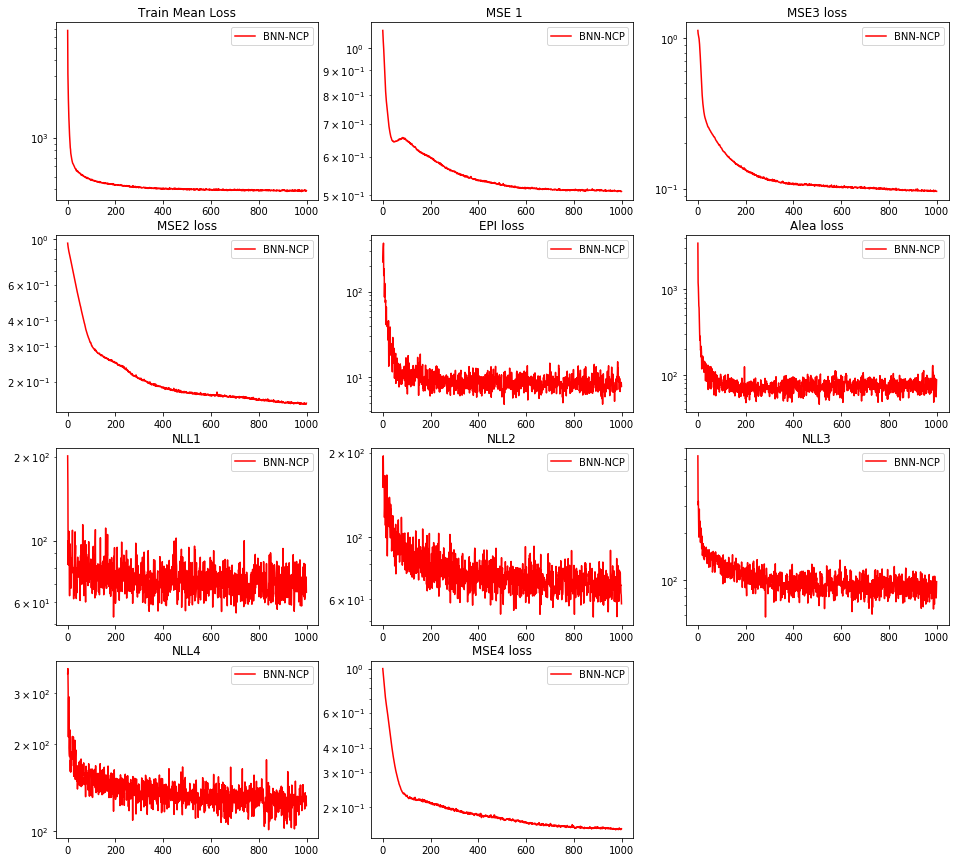

In [27]:

# Plotting training performance
# Plotting training performance
fig = plt.figure(figsize=(16, 15))
ax = fig.add_subplot(431)
ax2 = fig.add_subplot(432)
ax3 = fig.add_subplot(433)
ax4 = fig.add_subplot(434)
ax5 = fig.add_subplot(435)
ax6=fig.add_subplot(436)
ax7=fig.add_subplot(437)
ax8=fig.add_subplot(438)
ax9=fig.add_subplot(439)
ax10=fig.add_subplot(4,3,10)
ax11=fig.add_subplot(4,3,11)
ax.set_title("Train Mean Loss")
ax.plot(history[0], color='red', label='BNN-NCP',scaley='log')
ax.set_yscale('log')
ax.legend()

ax2.set_title(" MSE 1")
ax2.plot(history[1], color='red', label='BNN-NCP')
ax2.set_yscale('log')
ax2.legend()

ax4.set_title("MSE2 loss")
ax4.plot(history[2], color='red', label='BNN-NCP')
ax4.set_yscale('log')
ax4.legend()

ax3.set_title("MSE3 loss")
ax3.plot(history[3], color='red', label='BNN-NCP')
ax3.set_yscale('log')
ax3.legend()

ax5.set_title("EPI loss")
ax5.plot(mean_prior_weight*np.array(history[5]), color='red', label='BNN-NCP')
ax5.set_yscale('log')
ax5.legend()

ax6.set_title("Alea loss")
ax6.plot(noise_prior_weight*np.array(history[6]), color='red', label='BNN-NCP')
ax6.set_yscale('log')
ax6.legend()

ax7.set_title("NLL1")
ax7.plot(nll_weight*(np.array(history[7])), color='red', label='BNN-NCP')
ax7.set_yscale('log')
ax7.legend()

ax8.set_title("NLL2")
ax8.plot(nll_weight2*(np.array(history[8])), color='red', label='BNN-NCP')
ax8.set_yscale('log')
ax8.legend()

ax9.set_title("NLL3")
ax9.plot(nll_weight3*(np.array(history[9])), color='red', label='BNN-NCP')
ax9.set_yscale('log')
ax9.legend()

ax10.set_title("NLL4")
ax10.plot(nll_weight3*(np.array(history[10])), color='red', label='BNN-NCP')
ax10.set_yscale('log')
ax10.legend()

ax11.set_title("MSE4 loss")
ax11.plot(history[4], color='red', label='BNN-NCP')
ax11.set_yscale('log')
ax11.legend()

# plt.savefig('../figures/delete_later.png')

plt.show(block=False)





In [28]:
ndim_out_dist, mean_dist,ndim_out_dist2,mean_dist2,ndim_out_dist3,mean_dist3,ndim_out_dist4,mean_dist4=model([tf.constant(plasma['mu'].values,dtype=tf.float32),tf.constant(plasma['Bt[T]'].values,dtype=tf.float32),
    tf.constant(plasma['epsilon'].values,dtype=tf.float32),
    tf.constant(plasma['kappa'].values,dtype=tf.float32),tf.constant(plasma['Triang.'].values,dtype=tf.float32),tf.constant(plasma['P_tot[MW]'].values,dtype=tf.float32),
    tf.constant(plasma['Gas[1e22/s]'].values,dtype=tf.float32),tf.constant(plasma['Zeff_h'].values,dtype=tf.float32)])

In [29]:
def beta_fun(Te_ped=plasma0.Te_ped_exp.values,ne_ped=plasma0.ne_ped_exp.values,triang=plasma0['Triang.'].values,rminor=plasma0['rminor[m]'].values,kappa=plasma0.kappa.values,ip=plasma0['Ip[MA]'].values,zeff=plasma0.Zeff_h.values):
    mu0=4*np.pi*10**(-7)
    theta = np.linspace(0, 2*np.pi, 361).reshape(1,-1)
    dx = np.sin(theta + np.arcsin(triang.reshape(-1,1)) * np.sin(theta)) * (1 + np.arcsin(triang.reshape(-1,1)) * np.cos(theta))
    dy = kappa.reshape(-1,1) * np.cos(theta)
    Lp = rminor.reshape(-1,1) * np.trapz(np.sqrt(dx**2 + dy**2), theta).reshape(-1,1)
    Bp2 = (ip.reshape(-1,1)*1e6 * mu0 / Lp)**2
    pe_ped = ne_ped.reshape(-1,1)*1e19 * Te_ped.reshape(-1,1)*1.6e-16
    Zimp = 4
    pi_ped = pe_ped * (Zimp - zeff.reshape(-1,1)) / (Zimp - 1)
    beta = (pe_ped + pi_ped) * (2 * mu0) / Bp2
    return beta
def beta_error(Te_ped_error,Te_ped,ne_ped_error,ne_ped,triang=plasma0['Triang.'].values,rminor=plasma0['rminor[m]'].values,kappa=plasma0.kappa.values,ip=plasma0['Ip[MA]'].values,zeff=plasma0.Zeff_h.values):
    mu0=4*np.pi*10**(-7)
    theta = np.linspace(0, 2*np.pi, 361).reshape(1,-1)
    dx = np.sin(theta + np.arcsin(triang.reshape(-1,1)) * np.sin(theta)) * (1 + np.arcsin(triang.reshape(-1,1)) * np.cos(theta))
    dy = kappa.reshape(-1,1) * np.cos(theta)
    Lp = rminor.reshape(-1,1) * np.trapz(np.sqrt(dx**2 + dy**2), theta).reshape(-1,1)
    Bp2 = (ip.reshape(-1,1)*1e6 * mu0 / Lp)**2
    pe = ne_ped*1e19 * Te_ped*1.6e-16
    dpe=pe*(ne_ped_error/ne_ped+Te_ped_error/Te_ped)
    
    Zimp=4
    dpi=dpe*(Zimp-zeff.reshape(-1))/(Zimp-1)
    
    dbeta=(dpe+dpi)*2*mu0/Bp2.reshape(-1)
    return dbeta.reshape(-1)

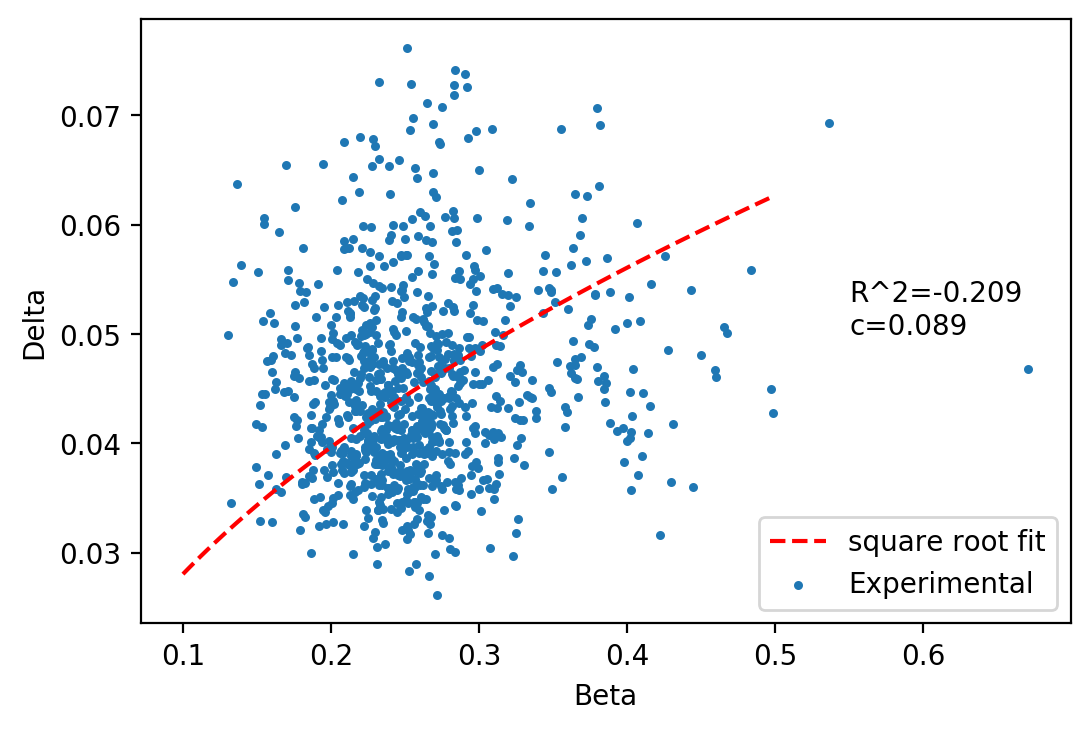

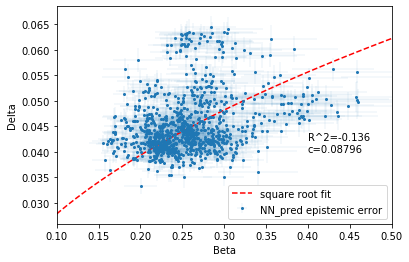

In [30]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
def f(x,a):
    return a*np.sqrt(x)
def un_norm(a,var):
    return a*myscaler(plasma0[var])[2]+myscaler(plasma0[var])[1]
#EXP
beta=beta_fun()
delta=plasma0.Delta_exp.values
dfbeta=pd.DataFrame({'delta_nn':delta.reshape(-1),'beta_nn':beta.reshape(-1),'z':plasma0.beta_n_exp.values.reshape(-1)})
# dfbeta[dfbeta['beta_nn']>100]=np.nan
# dfbeta=dfbeta.dropna(axis=0)
popt_exp,pcov=curve_fit(f,dfbeta.beta_nn,dfbeta.delta_nn,maxfev=50000)
x=np.linspace(0.1,0.5,100)
plt.figure(dpi=200)
plt.plot(x,f(x,popt_exp),'r--',label='square root fit')
plt.scatter(beta,delta,s=5,label='Experimental')#,c=plasma0.beta_n_exp.values.reshape(-1))
plt.ylabel('Delta')
plt.xlabel('Beta')
r2_exp=r2_score(dfbeta.delta_nn, f(dfbeta.beta_nn,popt_exp))
plt.annotate('R^2='+str(np.round(r2_exp,3))+'\n'+'c='+str(np.round(popt_exp[0],3)),xy=[0.55,0.05])
plt.legend()
plt.show()
import plotly.express as px
fig = px.scatter_3d(data_frame=dfbeta,x='beta_nn',y='delta_nn', z='z')
fig.update_traces(marker={'size': 1})
fig.show()
dfbeta_exp=dfbeta
#EPI
beta_nn=beta_fun((mean_dist2.mean().numpy()*myscaler(plasma0.Te_ped_exp)[2])+myscaler(plasma0.Te_ped_exp)[1],(mean_dist3.mean().numpy()*myscaler(plasma0.ne_ped_exp)[2])+myscaler(plasma0.ne_ped_exp)[1])#(mean_dist.mean().numpy().reshape(-1)*plasma.ne_ped_exp.values)/(plasma['Ip[MA]'].values)**2
delta_nn=(mean_dist.mean().numpy()*myscaler(plasma0.Delta_exp)[2])+myscaler(plasma0.Delta_exp)[1]
dfbeta=pd.DataFrame({'delta_nn':delta_nn.reshape(-1),'beta_nn':beta_nn.reshape(-1),
    'epi_beta':beta_error(Te_ped_error=mean_dist2.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_exp)[2],ne_ped_error=mean_dist3.stddev().numpy().reshape(-1)*myscaler(plasma0.ne_ped_exp)[2],Te_ped=un_norm(mean_dist2.mean().numpy().reshape(-1),'Te_ped_exp'),ne_ped=un_norm(mean_dist3.mean().numpy().reshape(-1),'ne_ped_exp')),
    'epi_delta':mean_dist.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_exp)[2],'z':((mean_dist4.mean().numpy()*myscaler(plasma0.beta_n_pred)[2])+myscaler(plasma0.beta_n_pred)[1]).reshape(-1)})
dfbeta[dfbeta['beta_nn']>100]=np.nan
dfbeta=dfbeta.dropna(axis=0)
plt.errorbar(dfbeta.beta_nn,dfbeta.delta_nn,yerr=dfbeta.epi_delta,xerr=dfbeta.epi_beta,label='NN_pred epistemic error',fmt='o',markersize=2,elinewidth=0.09)

popt_nn,pcov=curve_fit(f,dfbeta.beta_nn,dfbeta.delta_nn,sigma=dfbeta.epi_delta,maxfev=50000)
plt.xlim(0.1,0.5)
x=np.linspace(0.1,0.5,100)
plt.plot(x,f(x,popt_nn),'r--',label='square root fit')
r2_nn=r2_score(dfbeta.delta_nn, f(dfbeta.beta_nn,popt_nn))
plt.annotate('R^2='+str(np.round(r2_nn,3))+'\n'+'c='+str(np.round(popt_nn[0],5)),xy=[0.4,0.04])
plt.ylabel('Delta')
plt.xlabel('Beta')
plt.legend()
plt.show()
import plotly.express as px
fig = px.scatter_3d(data_frame=dfbeta,x='beta_nn',y='delta_nn', z='z')
fig.update_traces(marker={'size': 1})
fig.show()
dfbeta_epi=dfbeta

In [14]:
# C

In [31]:
dfbeta_exp
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D


# some 3-dim points
# mean = np.array([0.0,0.0,0.0])
# cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
# data = np.random.multivariate_normal(mean, cov, 50)
data=dfbeta_exp
def specific_3d_plot(data,titulo):
    # regular grid covering the domain of the data
    X,Y = np.meshgrid(np.arange(data['beta_nn'].min(),data['beta_nn'].max(), 0.01), np.arange(data['delta_nn'].min(), data['delta_nn'].max(), 0.005))
    XX = X.flatten()
    YY = Y.flatten()

    order = 1    # 1: linear, 2: quadratic
    if order == 1:
        # best-fit linear plane
        A = np.c_[data['beta_nn'].values, data['delta_nn'].values, np.ones(data.shape[0])]#
        C,_,_,_ = scipy.linalg.lstsq(A, data['z'].values)    # coefficients
        
        # evaluate it on grid
        Z = C[0]*X + C[1]*Y + C[2]
        
        # or expressed using matrix/vector product
        #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

    elif order == 2:
        # best-fit quadratic curve
        A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
        
        # evaluate it on a grid
        Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

    # plot points and fitted surface
    # fig = plt.figure()
    # ax = fig.gca(projection='3d')
    # ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
    # ax.scatter(data['beta_nn'].values, data['delta_nn'].values, data['z'].values, c='r', s=50)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # ax.set_zlabel('Z')
    # # ax.axis('equal')
    # ax.axis('tight')
    # plt.show()
    import plotly.graph_objects as go
    # fig = px.scatter_3d(data_frame=dfbeta,x='beta_nn',y='delta_nn', z='z')
    fig = go.Figure(data = [
        go.Surface(x = X,y = Y,z = Z,opacity=0.3,text='SJDSJHFBSDFH'), 
        go.Scatter3d(x=data['beta_nn'],y=data['delta_nn'], z=data['z'],mode='markers',marker=dict(
        size=1,
        colorscale='Viridis'),
        line=dict(
        color='darkblue',
        width=2
    ))])#data_frame=dfbeta_exp
    # fig.update_traces(marker={'size': 1})
    fig.update_layout(title=titulo,#xaxis_title="Beta Poloidal",
        # yaxis_title="Delta",zaxis_title='Beta total',
        scene=dict(xaxis_title='Beta Poloidal',
            yaxis_title='Delta (psi)',
            zaxis_title='Beta Total',annotations=[
            dict(
                showarrow=False,
                x=0.4,
                y=0.05,
                z=3.5,
                text="Beta_n="+str(C[0].round(2))+'Beta_p+'+str(C[1].round(2))+'Delta'+str(C[2].round(2)),
                xanchor="left",
                xshift=10,
                opacity=0.7)]
        ),
    )
    fig.show()
    fig.write_html('../figures/3Dplot/exp_plane_beta_n_'+titulo+'.html')
specific_3d_plot(dfbeta_exp,'Experimental')
# fig.write_html('../figures/exp_plane_beta_n_exp0,0,0.html')
specific_3d_plot(dfbeta_epi,'NN')